# Exploring the "Beer" dataset

Code by Julien Leuenberger

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import seaborn as sns

## Setting the path to the dataset

This should allow to move the current notebook and only change one line to keep the code working.

In [2]:
FILEPATH = "../../dataset"

BEERADVOCATE_REVIEW_LINES = 44022962
RATEBEER_RATING_LINES = 121075258

## Loading the dataset

For the tables which have two header rows, we can indicate this to pandas using `header=[0,1]` argument.

In [3]:
beers = pd.read_csv(f'{FILEPATH}/matched_beer_data/beers.csv', header=[0, 1])
breweries = pd.read_csv(f'{FILEPATH}/matched_beer_data/breweries.csv', header=[0, 1])
ratings = pd.read_csv(f'{FILEPATH}/matched_beer_data/ratings.csv', header=[0, 1])
users = pd.read_csv(f'{FILEPATH}/matched_beer_data/users.csv', header=[0, 1])

display(ratings)

ba                           \
        abv appearance aroma beer_id   
0      11.3       4.50  4.50     645   
1       5.0        NaN   NaN   28191   
2       5.0       3.50  3.50   57911   
3       5.0       4.00  3.50   57913   
4       6.0       4.00  4.00   81125   
...     ...        ...   ...     ...   
21959   8.5       4.50  3.50   28030   
21960   8.0       4.25  4.25    5057   
21961   5.2        NaN   NaN     349   
21962   6.5       3.00  3.00  127162   
21963  13.0       4.50  4.00   56774   

                                                                 \
                                           beer_name brewery_id   
0                            Trappistes Rochefort 10        207   
1                                 Myanmar Lager Beer       9369   
2      Cantillon Tyrnilambic Baie D’Argousier Lambic        388   
3                  Cantillon Pikkulinnun Viskilambic        388   
4         Drie Fonteinen Oude Geuze - Armand & Tommy       2216   
...                                              ...        ...   
21959                                  Valeir Divers       3463   
21960                                 Fantôme Saison        738   
21961                                        Jupiler        134   
21962                                       Redenaar      32560   
21963                Black Damnation III - Black Mes      15237   

                                                                  ...  \
                         brewery_name        date overall palate  ...   
0              Brasserie de Rochefort  1324810800     5.0   4.50  ...   
1      Myanmar Brewery and Distillery  1322650800     NaN    NaN  ...   
2                 Brasserie Cantillon  1344074400     4.0   4.00  ...   
3                 Brasserie Cantillon  1344074400     4.0   4.00  ...   
4               Brouwerij 3 Fonteinen  1346234400     4.0   4.00  ...   
...                               ...         ...     ...    ...  ...   
21959             Brouwerij Contreras  1323946800     4.0   4.00  ...   
21960               Brasserie Fantôme  1484046000     4.0   4.00  ...   
21961             Brasserie Piedboeuf  1393239600     NaN    NaN  ...   
21962      Brouwerij d'Oude Maalderij  1419764400     3.0   2.75  ...   
21963             De Struise Brouwers  1272794400     4.0   4.50  ...   

                                   rb                                    \
                         brewery_name        date overall palate rating   
0                 Brasserie Rochefort  1387710000    19.0    4.0    4.6   
1      Myanmar Brewery and Distillery  1322564400     6.0    2.0    1.7   
2                           Cantillon  1353582000    17.0    4.0    4.1   
3                           Cantillon  1416222000    16.0    4.0    4.1   
4               Brouwerij 3 Fonteinen  1345284000    16.0    4.0    4.0   
...                               ...         ...     ...    ...    ...   
21959                       Contreras  1323946800    15.0    4.0    3.7   
21960               Brasserie Fantôme  1487502000    16.0    4.0    4.0   
21961     Brasserie Piedboeuf (InBev)  1393153200     1.0    1.0    1.2   
21962                dOude Maalderij  1397037600    17.0    3.0    3.9   
21963             De Struise Brouwers  1272794400    17.0    4.0    4.0   

                                       \
                          style taste   
0                 Abt/Quadrupel   9.0   
1                    Pale Lager   4.0   
2          Lambic Style - Fruit   8.0   
3      Lambic Style - Unblended   9.0   
4         Lambic Style - Gueuze   8.0   
...                         ...   ...   
21959              Abbey Tripel   7.0   
21960                    Saison   8.0   
21961                Pale Lager   2.0   
21962               Belgian Ale   8.0   
21963            Imperial Stout   8.0   

                                                                  \
                                                    text user_id   
0       a)  Geruch m

## Exploring the dataset

In the following, we will explore a bit the dataset.

In [4]:
print(f"The BeerAdvocate's users has published {users['ba']['nbr_ratings'].sum()} ratings")
print(f"The RateBeer's users has published {users['rb']['nbr_ratings'].sum()} ratings")

The BeerAdvocate's users has published 664103 ratings
The RateBeer's users has published 862807 ratings


## Hypothesis: are there beer influencers?

There a multiple ways to go, like:
* Looking at the ratings of a beer over time and look for sudden changes. The users who rated the beer at that time could be the influencers.
* Comparing the ratings of a beer among the two datasets. When the evolution of the ratings in one dataset suddenly changes compared to the other, the users who rated the beer at that time could be the influencers.

In the following, we will use the second approach. The main part will consist of finding a method on how to attribute a "influencer score" to each user.

Each review for BeerAdvocate is in the following format:
```
beer_name: Barelegs Brew
beer_id: 19590
brewery_name: Strangford Lough Brewing Company Ltd
brewery_id: 10093
style: English Pale Ale
abv: 4.5
date: 1235127600
user_name: StJamesGate
user_id: stjamesgate.163714
appearance: 3.0
aroma: 3.5
palate: 3.5
taste: 4.0
overall: 3.5
rating: 3.67
text: Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy corn and brack malts. Clingy. Dries out at the end with more hops. Brave, more going on that usual for this type.
```

Also note that `overall` is a subjective rating set by the user, while `rating` is the average of `appearance`, `aroma` and `taste`.

### BeerAdvocate

In [5]:
beers_ba = pd.read_csv(f'{FILEPATH}/BeerAdvocate/beers.csv')

reviews_ba = {
    "beer_id": [],
    "user_id": [],
    "date": [],
    "overall": [],
    "rating": [],
}

with open(f'{FILEPATH}/BeerAdvocate/reviews.txt', 'r', encoding='utf-8') as f:
    for index, line in enumerate(tqdm(f, total=BEERADVOCATE_REVIEW_LINES)):
        if line.startswith("beer_id: "):
            reviews_ba["beer_id"].append(int(line[len("beer_id: "):].strip()))
        elif line.startswith("user_id: "):
            reviews_ba["user_id"].append(line[len("user_id: "):].strip())
        elif line.startswith("date: "):
            reviews_ba["date"].append(float(line[len("date: "):].strip()))
        elif line.startswith("overall: "):
            reviews_ba["overall"].append(float(line[len("overall: "):].strip()))
        elif line.startswith("rating: "):
            reviews_ba["rating"].append(float(line[len("rating: "):].strip()))

        if index == 100 and False:
            break

reviews_ba = pd.DataFrame(reviews_ba)
reviews_ba.sort_values(by=['date'], inplace=True)
display(reviews_ba)


100%|██████████| 44022962/44022962 [00:23<00:00, 1898849.22it/s]


,beer_id,user_id,date,overall,rating
1044348,93,todd.2,8.407080e+08,4.00,3.85
1025529,111,todd.2,8.844300e+08,4.00,4.19
494422,97,beeradvocate.1,8.846892e+08,4.50,4.10
1958517,51,beeradvocate.1,8.853804e+08,4.00,3.77
26272,306,beeradvocate.1,8.854668e+08,1.00,1.60
...,...,...,...,...,...
2354286,78838,woodbrew.549902,1.501495e+09,4.00,3.93
2534668,5366,blackop555.1183557,1.501495e+09,3.00,2.98
2173272,355,andrewh995.1184297,1.501495e+09,3.75,3.91
2479210,34312,mtn.766653,1.501582e+09,3.75,3.79


Looking for beer 2093
Looking for beer 11757
Looking for beer 412
Looking for beer 7971
Looking for beer 1093


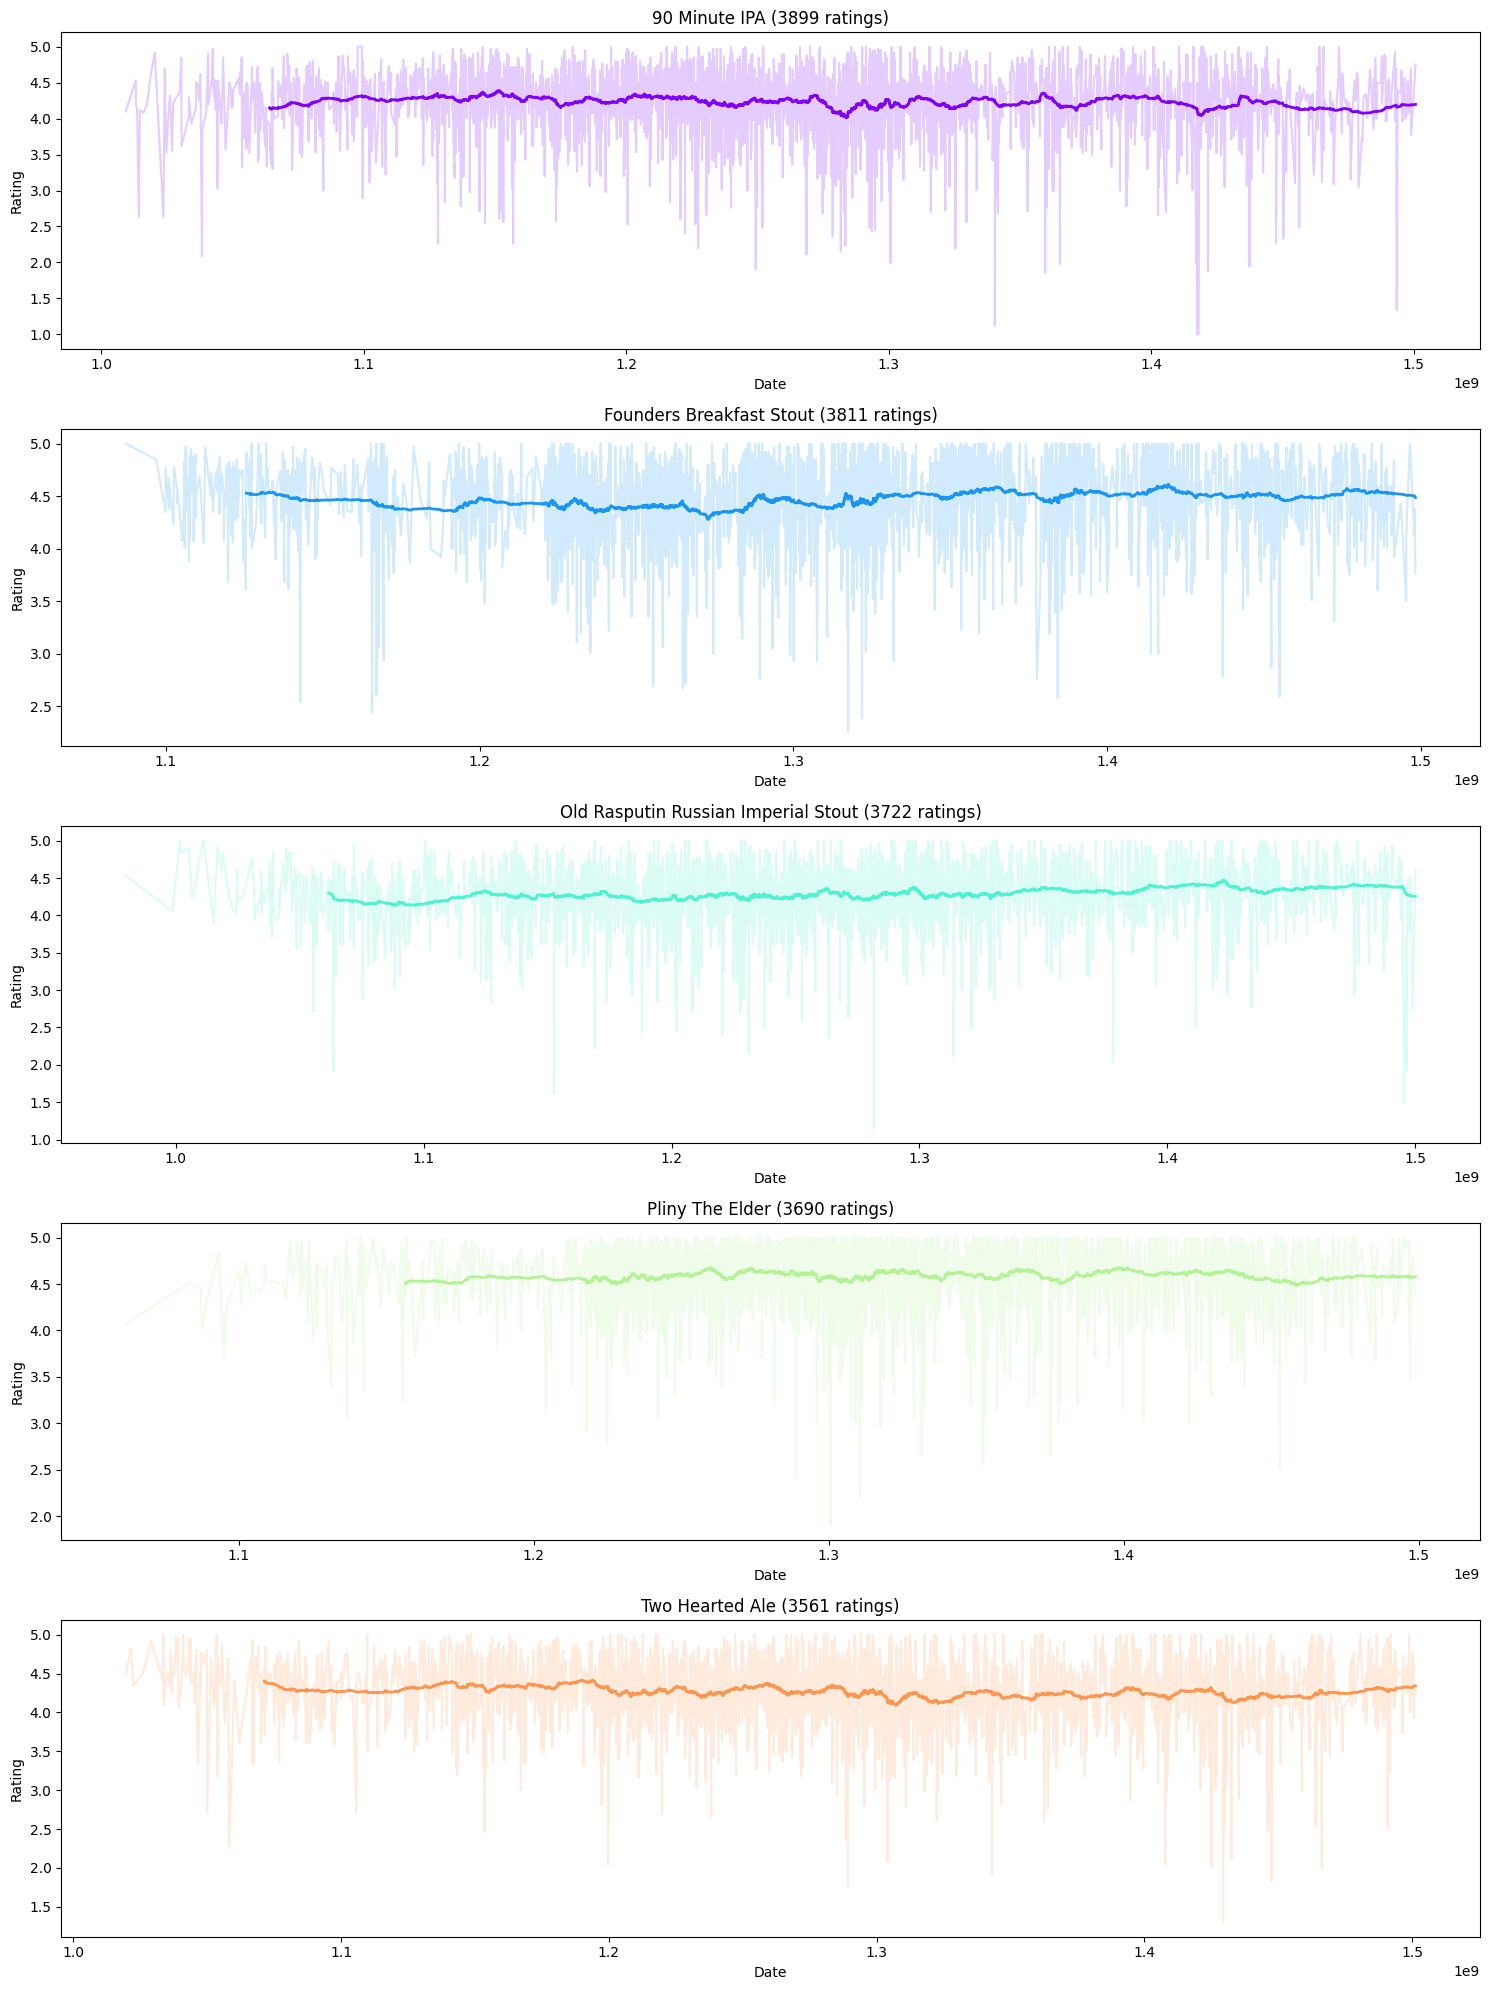

In [25]:
# Getting indices and counts for most popular beers

beer_indices_ba = reviews_ba.groupby("beer_id").count().index.values
beer_reviews_ba = reviews_ba.groupby("beer_id").count()["rating"].values
beer_indices_ba = beer_indices_ba[np.argsort(beer_reviews_ba)[::-1]]
beer_reviews_ba = np.sort(beer_reviews_ba)[::-1]

# MIN_RATINGS = 3000
# top_beer_indices = beer_indices[np.where(np.array(beer_reviews) > MIN_RATINGS)]
# top_beer_reviews = np.array(beer_reviews)[np.where(np.array(beer_reviews) > MIN_RATINGS)]
# print(f"There are {len(top_beer_indices)} beers with more than {MIN_RATINGS} ratings")

NUMBER_OF_BEERS = 5
top_beer_indices = beer_indices_ba[:NUMBER_OF_BEERS]
top_beer_reviews = beer_reviews_ba[:NUMBER_OF_BEERS]

# Displaying the time series for the most popular beers

fig, axes = plt.subplots(nrows=NUMBER_OF_BEERS, ncols=1, figsize=(15, 20))
for beer_rank, beer_index in enumerate(top_beer_indices):
    current_beer_review = reviews_ba.query("beer_id == @beer_index")
    current_beer_dates = current_beer_review["date"].values
    current_beer_ratings = current_beer_review["rating"].values
    color = plt.cm.rainbow(beer_rank / NUMBER_OF_BEERS)
    axes[beer_rank].plot(current_beer_dates, current_beer_ratings, color=color, alpha=0.2)

    sma = pd.DataFrame(current_beer_ratings).rolling(100).mean().values.flatten()
    axes[beer_rank].plot(current_beer_dates, sma, color=color, linewidth=2)

    print(f"Looking for beer {beer_index}")
    beer_name = beers_ba.query("beer_id == @beer_index")["beer_name"].values[0]
    axes[beer_rank].set(title=f"{beer_name} ({top_beer_reviews[beer_rank]} ratings)", xlabel="Date", ylabel="Rating")

plt.tight_layout()

### RateBeer

**In seems that there is no `reviews.txt` for RateBeer. Instead, `reviews.txt.gz` contains `ratings.txt`.**

In [7]:
beers_rb = pd.read_csv(f'{FILEPATH}/RateBeer/beers.csv')

reviews_rb = {
    "beer_id": [],
    "user_id": [],
    "date": [],
    "overall": [],
    "rating": [],
}

with open(f'{FILEPATH}/RateBeer/ratings.txt', 'r', encoding='utf-8') as f:
    for index, line in enumerate(tqdm(f, total=RATEBEER_RATING_LINES)):
        if line.startswith("beer_id: "):
            reviews_rb["beer_id"].append(int(line[len("beer_id: "):].strip()))
        elif line.startswith("user_id: "):
            reviews_rb["user_id"].append(line[len("user_id: "):].strip())
        elif line.startswith("date: "):
            reviews_rb["date"].append(float(line[len("date: "):].strip()))
        elif line.startswith("overall: "):
            reviews_rb["overall"].append(float(line[len("overall: "):].strip()))
        elif line.startswith("rating: "):
            reviews_rb["rating"].append(float(line[len("rating: "):].strip()))

        if index == 100 and False:
            break

reviews_rb = pd.DataFrame(reviews_rb)
reviews_rb.sort_values(by=['date'], inplace=True)
display(reviews_rb)


100%|██████████| 121075258/121075258 [01:02<00:00, 1931575.86it/s]


,beer_id,user_id,date,overall,rating
6050077,132,3,9.555336e+08,17.0,4.2
4534366,121,15,9.555336e+08,20.0,4.7
5973188,286,2,9.558792e+08,18.0,4.4
6250732,880,23,9.564840e+08,3.0,1.7
5257470,596,2,9.564840e+08,17.0,4.3
...,...,...,...,...,...
6919747,4663,252123,1.501495e+09,16.0,3.9
7093306,335019,121469,1.501495e+09,15.0,3.8
6305541,369564,30799,1.501495e+09,14.0,3.3
6358557,180565,5328,1.501495e+09,13.0,3.2


Looking for beer 2360
Looking for beer 1267
Looking for beer 53
Looking for beer 835
Looking for beer 2530


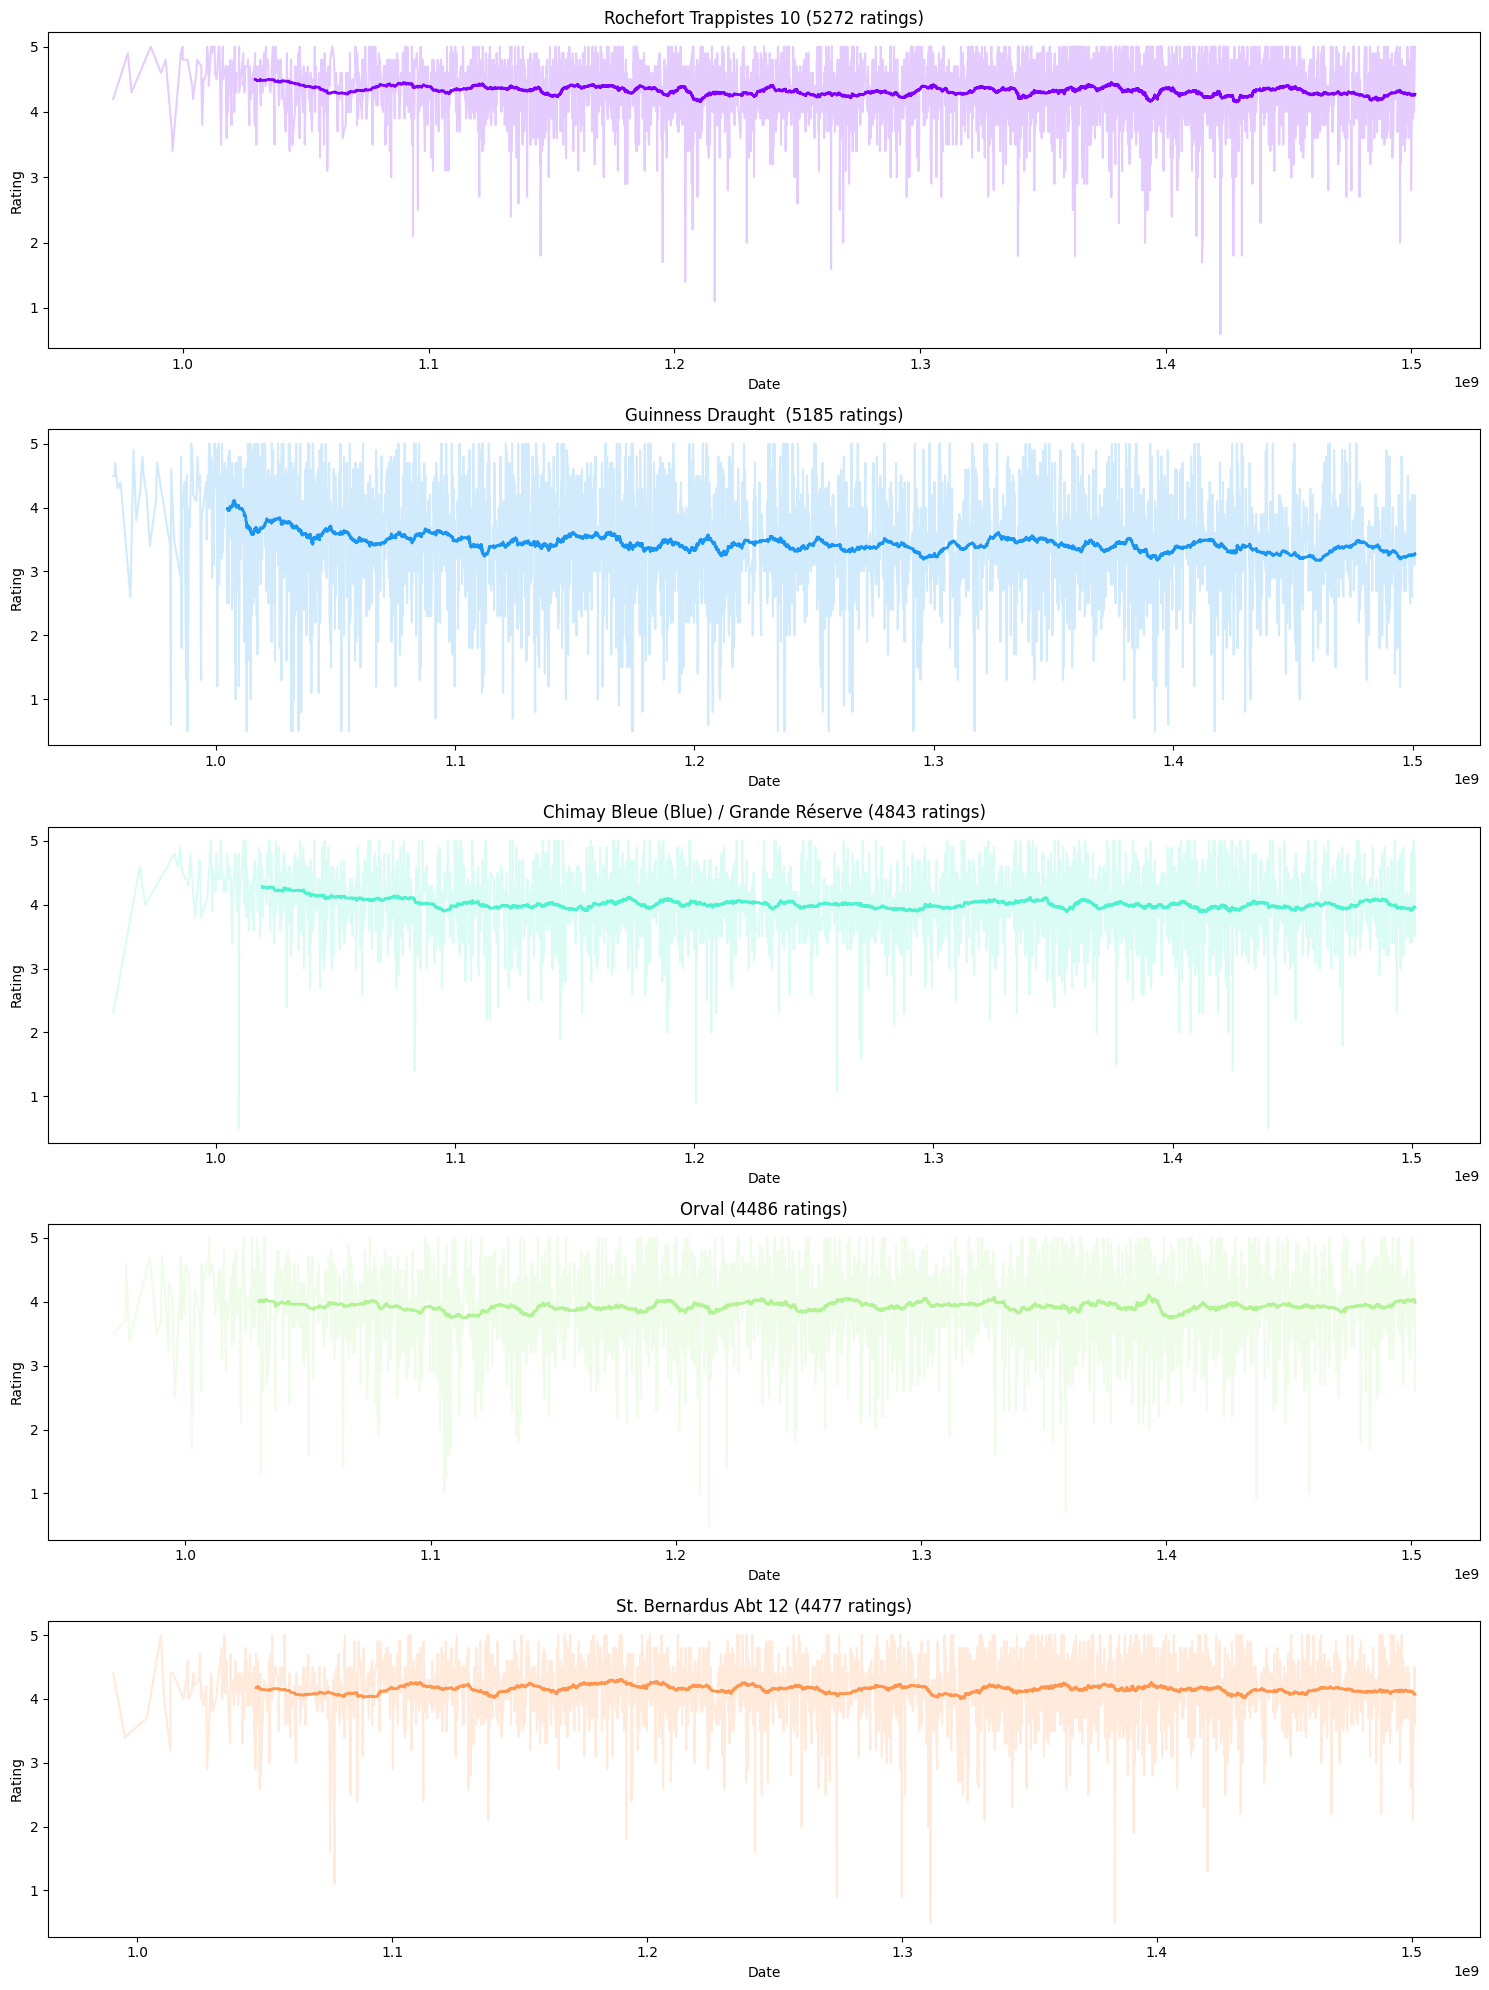

In [26]:
# Getting indices and counts for most popular beers

beer_indices_rb = reviews_rb.groupby("beer_id").count().index.values
beer_reviews_rb = reviews_rb.groupby("beer_id").count()["rating"].values
beer_indices_rb = beer_indices_rb[np.argsort(beer_reviews_rb)[::-1]]
beer_reviews_rb = np.sort(beer_reviews_rb)[::-1]

# MIN_RATINGS = 3000
# top_beer_indices = beer_indices[np.where(np.array(beer_reviews) > MIN_RATINGS)]
# top_beer_reviews = np.array(beer_reviews)[np.where(np.array(beer_reviews) > MIN_RATINGS)]
# print(f"There are {len(top_beer_indices)} beers with more than {MIN_RATINGS} ratings")

NUMBER_OF_BEERS = 5
top_beer_indices = beer_indices_rb[:NUMBER_OF_BEERS]
top_beer_reviews = beer_reviews_rb[:NUMBER_OF_BEERS]

# Displaying the time series for the most popular beers

fig, axes = plt.subplots(nrows=NUMBER_OF_BEERS, ncols=1, figsize=(15, 20))
for beer_rank, beer_index in enumerate(top_beer_indices):
    current_beer_review = reviews_rb.query("beer_id == @beer_index")
    current_beer_dates = current_beer_review["date"].values
    current_beer_ratings = current_beer_review["rating"].values
    color = plt.cm.rainbow(beer_rank / NUMBER_OF_BEERS)
    axes[beer_rank].plot(current_beer_dates, current_beer_ratings, color=color, alpha=0.2)

    sma = pd.DataFrame(current_beer_ratings).rolling(100).mean().values.flatten()
    axes[beer_rank].plot(current_beer_dates, sma, color=color, linewidth=2)

    print(f"Looking for beer {beer_index}")
    beer_name = beers_rb.query("beer_id == @beer_index")["beer_name"].values[0]
    axes[beer_rank].set(title=f"{beer_name} ({top_beer_reviews[beer_rank]} ratings)", xlabel="Date", ylabel="Rating")

plt.tight_layout()

### Comparing BeerAdvocate and RateBeer

Since the most popular beers from each website aren't the same, it will be important to compare the same beers. In order to do that, we start by building matchings between the two dataset beer's IDs.

In [23]:
# Joining beers datasets
# NOTE: This will allow to math the beers from both datasets based on their
# name, and get the ID from both datasets.

beers = beers_ba.join(beers_rb.set_index("beer_name"), on="beer_name", lsuffix="_ba", rsuffix="_rb")

# Remove all columns except
# - beer_id_ba
# - beer_id_rb
# - beer_name

beers = beers[["beer_id_ba", "beer_id_rb", "beer_name"]]

display(beers)

,beer_id_ba,beer_id_rb,beer_name
0,166064,38714.0,Nashe Moskovskoe
1,166065,149575.0,Nashe Pivovskoe
2,166066,38715.0,Nashe Shakhterskoe
3,166067,39000.0,Nashe Zhigulevskoe
4,166063,NaN,Zhivoe
...,...,...,...
280818,19139,NaN,Kölsch Ale
280819,19140,NaN,Nut Brown Ale
280820,19146,NaN,Octoberfest
280821,2805,NaN,Scotch Ale


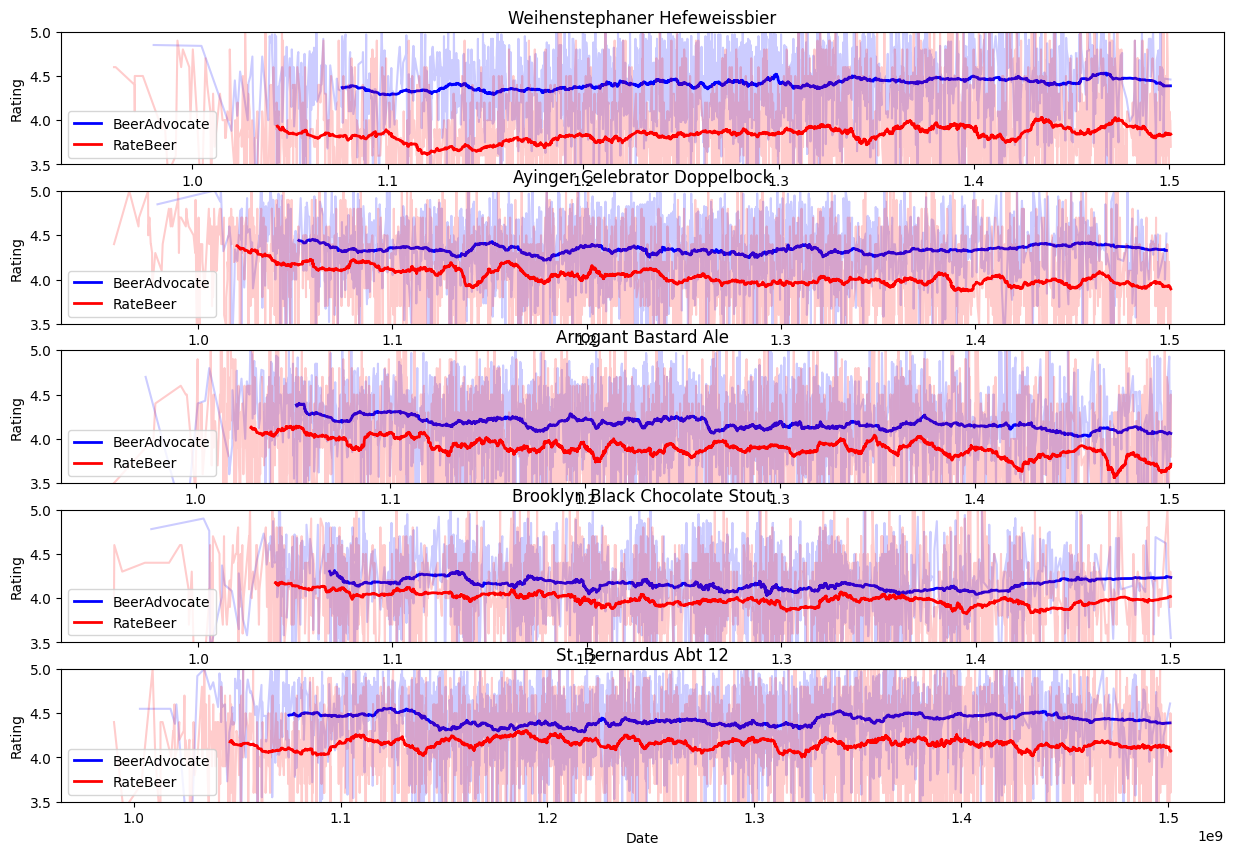

In [53]:
# Extracting the most popular beer names from each website

NUMBER_OF_BEERS = 50
top_beer_indices_rb = beer_indices_rb[:NUMBER_OF_BEERS]
top_beer_reviews_rb = beer_reviews_rb[:NUMBER_OF_BEERS]
top_beer_indices_ba = beer_indices_ba[:NUMBER_OF_BEERS]
top_beer_reviews_ba = beer_reviews_ba[:NUMBER_OF_BEERS]
top_beer_names_rb = beers_rb.query("beer_id in @top_beer_indices_rb")["beer_name"].values
top_beer_names_ba = beers_ba.query("beer_id in @top_beer_indices_ba")["beer_name"].values

# Filtering these items to keep only the ones that are in both datasets

valid_names = beers.dropna()["beer_name"]
top_beer_names_rb = top_beer_names_rb[np.where(np.isin(top_beer_names_rb, valid_names))]
top_beer_names_ba = top_beer_names_ba[np.where(np.isin(top_beer_names_ba, valid_names))]

# Filtering these items to keep only the ones that are in the other list

top_beer_names_rb = top_beer_names_rb[np.where(np.isin(top_beer_names_rb, top_beer_names_ba))]
top_beer_names_ba = top_beer_names_ba[np.where(np.isin(top_beer_names_ba, top_beer_names_rb))]

fig, ax = plt.subplots(nrows=len(top_beer_names_ba), ncols=1, figsize=(15, 10))
for index, beer_name in enumerate(top_beer_names_rb):
    # Plot BA time series
    beer_id = beers.query("beer_name == @beer_name")["beer_id_ba"].values[0]
    reviews = reviews_ba.query("beer_id == @beer_id")
    dates = reviews["date"].values
    ratings = reviews["rating"].values
    ax[index].plot(dates, ratings, color="blue", alpha=0.2)
    sma = pd.DataFrame(ratings).rolling(100).mean().values.flatten()
    ax[index].plot(dates, sma, color="blue", linewidth=2, label="BeerAdvocate")

    # Plot RB time series
    beer_id = beers.query("beer_name == @beer_name")["beer_id_rb"].values[0]
    reviews = reviews_rb.query("beer_id == @beer_id")
    dates = reviews["date"].values
    ratings = reviews["rating"].values
    ax[index].plot(dates, ratings, color="red", alpha=0.2)
    sma = pd.DataFrame(ratings).rolling(100).mean().values.flatten()
    ax[index].plot(dates, sma, color="red", linewidth=2, label="RateBeer")

    ax[index].set(title=f"{beer_name}", xlabel="Date", ylabel="Rating")
    ax[index].set(ylim=(3.5, 5))
    ax[index].legend()